In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.image import resize
from sklearn.model_selection import train_test_split
from skimage.restoration import denoise_tv_chambolle

train_df = pd.read_csv('/content/drive/MyDrive/Example data set/SignNet_Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Example data set/SignNet_Test (1).csv')

label_to_alphabet = { 0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M',
                     13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y' }



In [ ]:
def preprocess_data(df):
    X = df.drop(columns=['label']).values
    y = df['label'].values
    X = X / 255.0
    X = X.reshape(-1, 28, 28, 1)
    y = to_categorical(y, num_classes=25)
    return X, y

X_train, y_train = preprocess_data(train_df)
X_test, y_test = preprocess_data(test_df)

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

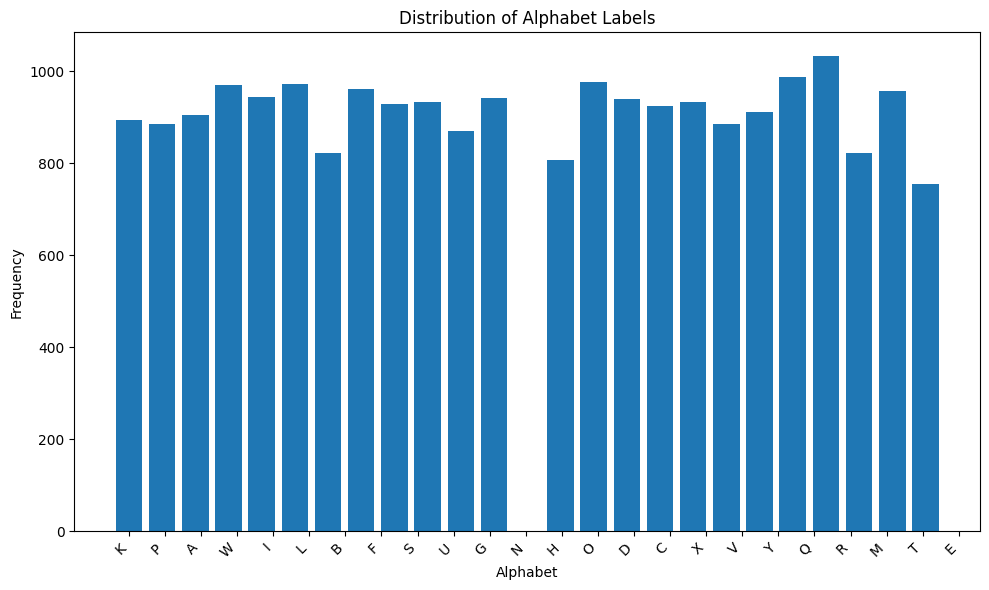

In [ ]:
def plot_label_histogram(labels, label_to_alphabet):
  alphabet_labels = [label_to_alphabet[label] for label in labels]

  plt.figure(figsize=(10, 6))
  plt.hist(alphabet_labels, bins=len(label_to_alphabet), align='left', rwidth=0.8)
  plt.xlabel('Alphabet')
  plt.ylabel('Frequency')
  plt.title('Distribution of Alphabet Labels')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

plot_label_histogram(np.argmax(y_train, axis=1), label_to_alphabet)

In [ ]:
def SignNet():
    model = Sequential()

    model.add(Input(shape=(28, 28, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.6))
    model.add(Dense(25, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

model = SignNet()

train_dataset = datagen.flow(X_train, y_train, batch_size=64)

history = model.fit(train_dataset,
                    validation_data=(X_val, y_val),
                    epochs=25,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3300 - loss: 2.9422 - val_accuracy: 0.2295 - val_loss: 3.3186 - learning_rate: 0.0010
Epoch 2/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7922 - loss: 0.9081 - val_accuracy: 0.9142 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 3/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8985 - loss: 0.5944 - val_accuracy: 0.8955 - val_loss: 0.5867 - learning_rate: 0.0010
Epoch 4/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9293 - loss: 0.4858 - val_accuracy: 0.9701 - val_loss: 0.3491 - learning_rate: 0.0010
Epoch 5/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.9530 - loss: 0.3959 - val_accuracy: 0.9834 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 6/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.9603 - loss: 0.3565 - val_accuracy: 0.9188 - val_loss: 0.4715 - learning_rate: 0.0010
Epoch 7/25
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9665 - los

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           6,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 400,205 (1.53 MB)

 Trainable params: 133,081 (519.85 KB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 266,164 (1.02 MB)

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9973 - loss: 0.0943
Test accuracy: 0.9968


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

print("Classification Report: ")
print(classification_report(y_true, y_pred_classes))

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       1.00      1.00      1.00       245
           4       1.00      1.00      1.00       498
           5       1.00      1.00      1.00       247
           6       1.00      1.00      1.00       348
           7       1.00      1.00      1.00       436
           8       1.00      1.00      1.00       288
          10       1.00      1.00      1.00       331
          11       1.00      1.00      1.00       209
          12       1.00      1.00      1.00       394
          13       1.00      1.00      1.00       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17    

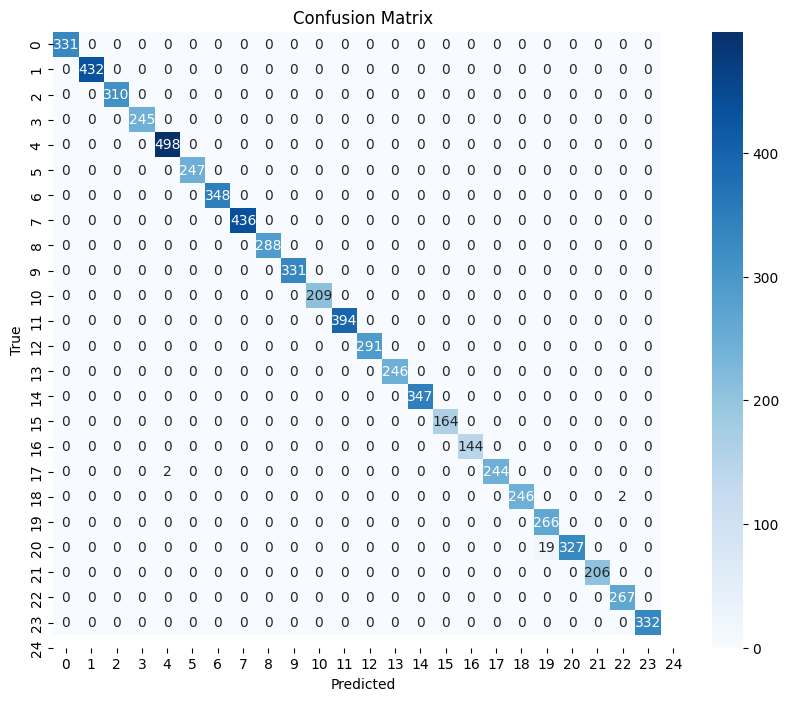

In [ ]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(25), yticklabels=np.arange(25))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

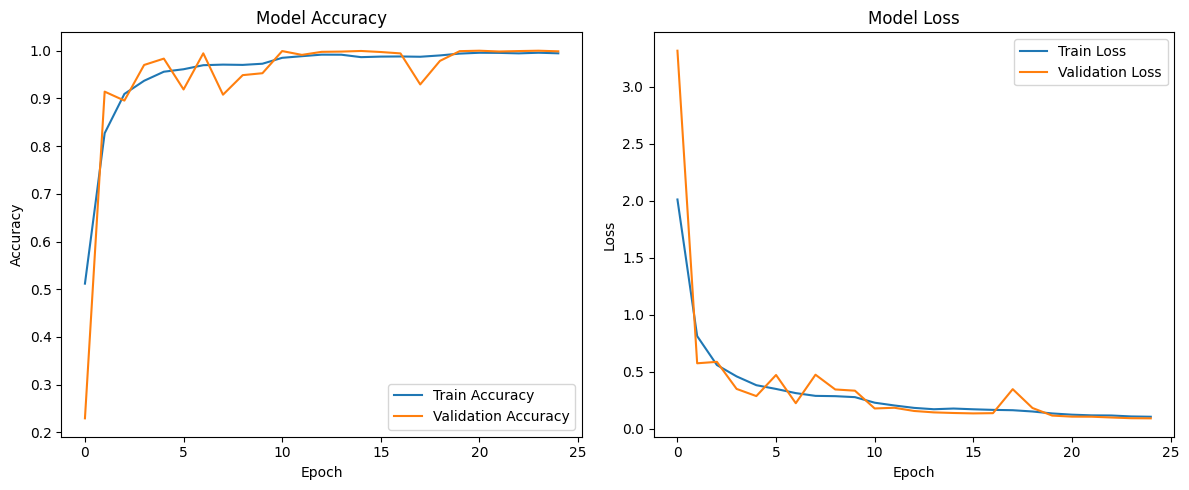

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


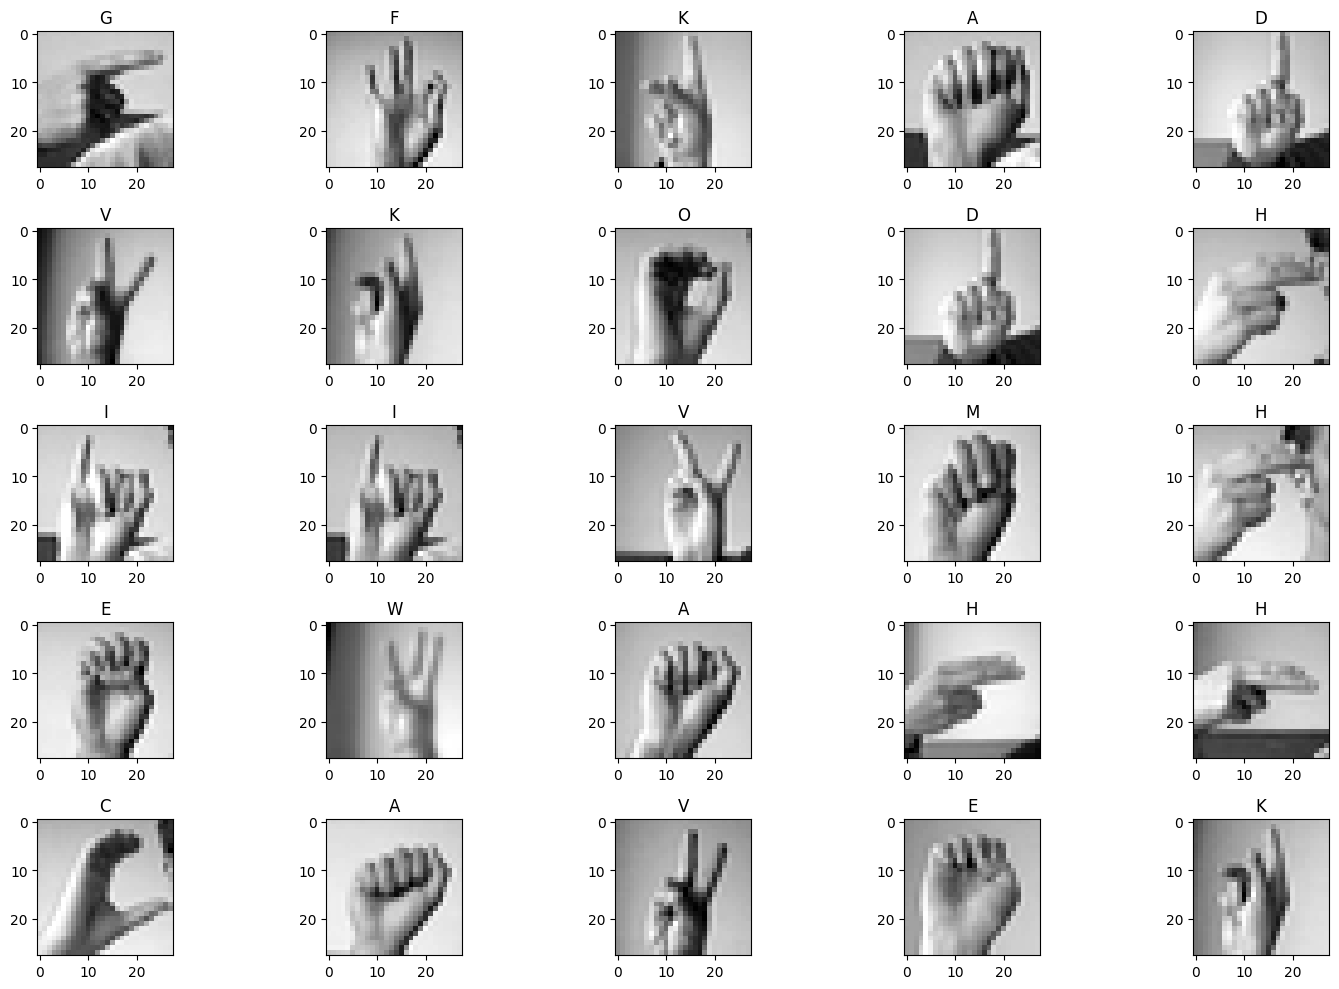

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

y_pred_labels = [label_to_alphabet[i] for i in y_pred_classes]
y_true_labels = [label_to_alphabet[i] for i in y_true_classes]

def plot_alphabet_images(X, y_true, n=25):

    num_rows = 5
    num_cols = 5
    plt.figure(figsize=(15, 10))
    for i in range(n):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.axis('on')
        plt.title(f"{y_true[i]}")
    plt.tight_layout()
    plt.show()


plot_alphabet_images(X_test, y_true_labels, n=25)


own model creation

In [ ]:
def MySignNet():
    model = Sequential()

    model.add(Input(shape=(28, 28, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0005)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(25, activation='softmax'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

my_model = MySignNet()

train_dataset = datagen.flow(X_train, y_train, batch_size=64)

history_my_model = my_model.fit(train_dataset,
                                validation_data=(X_val, y_val),
                                epochs=50,
                                callbacks=[early_stopping, reduce_lr])

Epoch 1/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.4487 - loss: 2.3544 - val_accuracy: 0.0630 - val_loss: 4.0424 - learning_rate: 5.0000e-04
Epoch 2/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8788 - loss: 0.6613 - val_accuracy: 0.9787 - val_loss: 0.4000 - learning_rate: 5.0000e-04
Epoch 3/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9506 - loss: 0.4374 - val_accuracy: 0.9767 - val_loss: 0.3627 - learning_rate: 5.0000e-04
Epoch 4/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9703 - loss: 0.3716 - val_accuracy: 0.9780 - val_loss: 0.3361 - learning_rate: 5.0000e-04
Epoch 5/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9763 - loss: 0.3433 - val_accuracy: 0.9820 - val_loss: 0.3158 - learning_rate: 5.0000e-04
Epoch 6/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9810 - loss: 0.3141 - val_accuracy: 0.9818 - val_loss: 0.3070 - learning_rate: 5.0000e-04
Epoch 7/50
344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - 

In [ ]:
my_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 25)                  │          12,825 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,549,901 (5.91 MB)

 Trainable params: 515,993 (1.97 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 1,031,988 (3.94 MB)

In [ ]:
test_loss, test_acc = my_model.evaluate(X_test, y_test)
print(f"My Model Test accuracy: {test_acc:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9951 - loss: 0.0710
My Model Test accuracy: 0.9951


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

print("Classification Report: ")
print(classification_report(y_true, y_pred_classes))

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       0.96      0.94      0.95       245
           4       0.97      1.00      0.99       498
           5       1.00      1.00      1.00       247
           6       0.97      1.00      0.98       348
           7       1.00      0.97      0.99       436
           8       1.00      1.00      1.00       288
          10       1.00      0.97      0.99       331
          11       1.00      1.00      1.00       209
          12       0.97      1.00      0.98       394
          13       1.00      0.96      0.98       291
          14       1.00      1.00      1.00       246
          15       1.00      1.00      1.00       347
          16       1.00      1.00      1.00       164
          17    

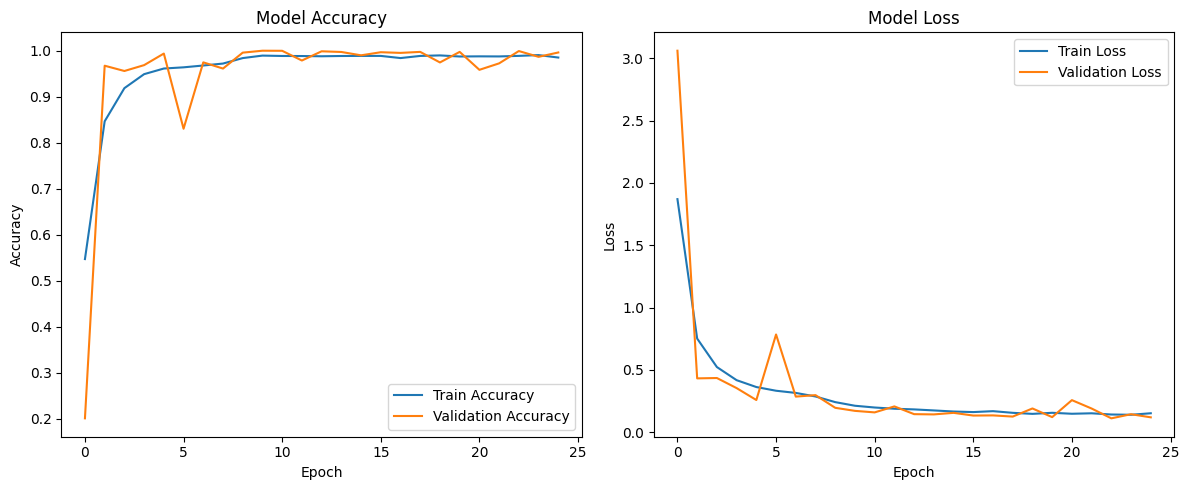

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


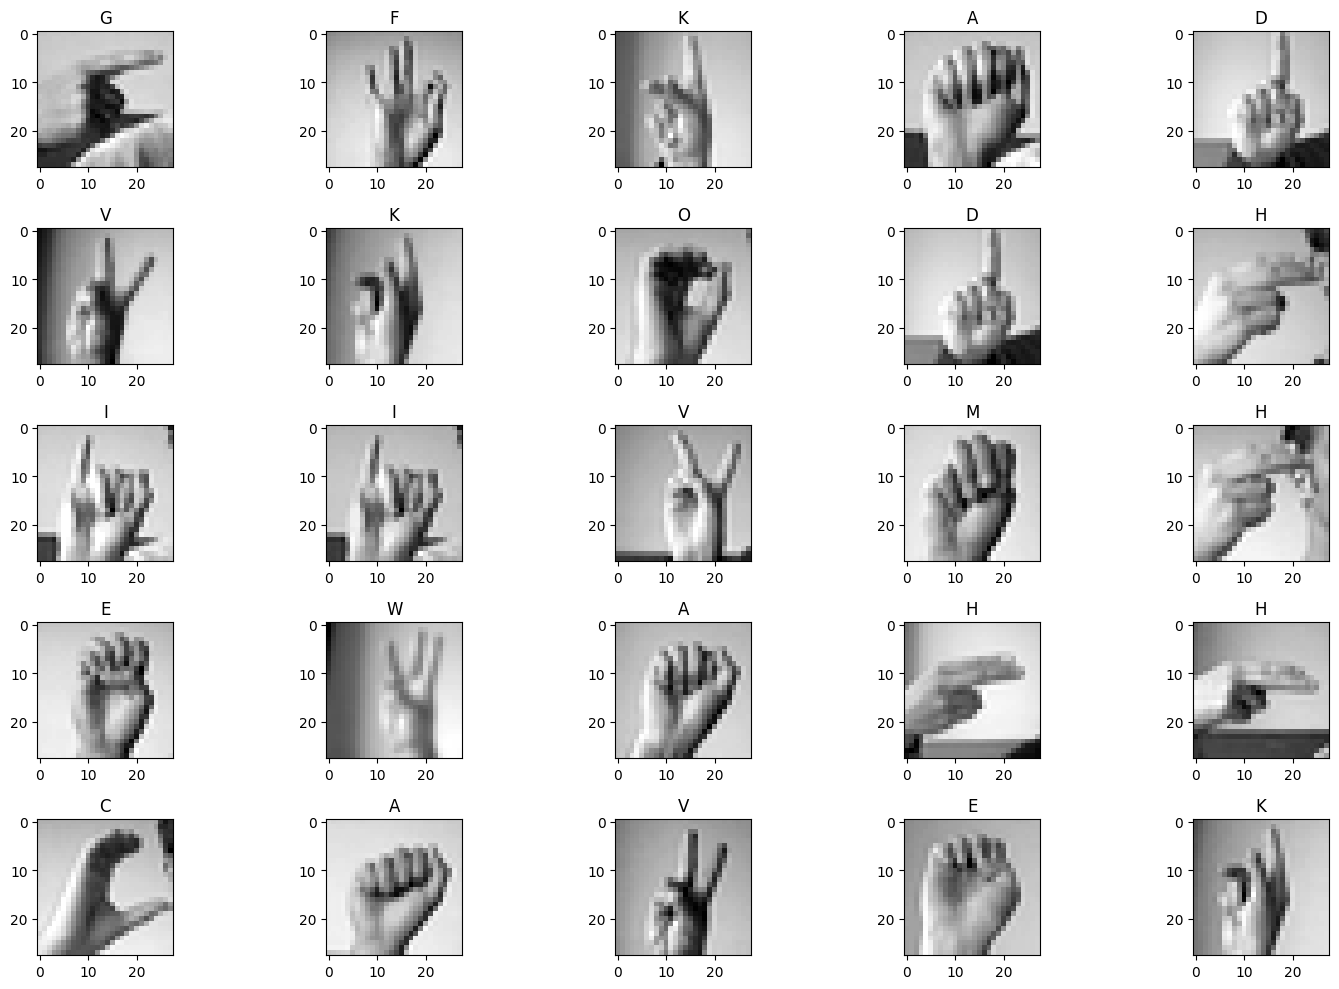

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

y_pred_labels = [label_to_alphabet[i] for i in y_pred_classes]
y_true_labels = [label_to_alphabet[i] for i in y_true_classes]

def plot_alphabet_images(X, y_true, n=25):

    num_rows = 5
    num_cols = 5
    plt.figure(figsize=(15, 10))
    for i in range(n):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.axis('on')
        plt.title(f"{y_true[i]}")
    plt.tight_layout()
    plt.show()


plot_alphabet_images(X_test, y_true_labels, n=25)
